In [2]:
import os
import numpy as np
import astropy as ap
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_moon
from astropy.coordinates.angle_utilities import angular_separation
import astropy.units as u
from astropy.time import Time
from astroplan import Observer
from datetime import datetime, timedelta
import pdb

In [3]:
# constants
DEG_TO_RAD = np.pi/180
hourOffset = -10 # Hawaii is 10 hours behind utc.
keck = EarthLocation.of_site('Keck Observatory')
keckObs = Observer.at_site("Keck Observatory", timezone="US/Hawaii")
utcoffset = hourOffset * u.hour  # Hawaii Daylight Time
#inputs (to be input)
ra, dec = "17:31:16", "+33:27:43"
now = Time(datetime.now())

In [4]:
now

<Time object: scale='utc' format='datetime' value=2021-10-18 08:24:33.296227>

In [5]:
nearestSet = keckObs.sun_set_time(Time(now), which='next') + utcoffset
nearestSet.iso

'2021-10-18 17:52:14.895'

In [37]:
def get_midnight(now):
    utcoffset = hourOffset * u.hour  # Hawaii Daylight Time
    nextSet = keckObs.sun_set_time(now, which='next') 
    nextRise = keckObs.sun_rise_time(now, which='next') 
    if nextRise > nextSet: # today's midnight already occured
        print('using today\'s midnight')
        midnight= Time(keckObs.midnight(now+timedelta(days=1), which='next'))
    else: 
        print('using yesterday\'s midnight')
        midnight = Time(keckObs.midnight(now, which='nearest'))
    return midnight + utcoffset

def get_times(midnight):
    deltaMidnight = np.linspace(-6, 6, 20)*u.hour
    return midnight+deltaMidnight

def get_target_frame():
    now = Time(datetime.now())
    midnight = get_midnight(now)
    times = get_times(midnight)
    tgtFrame = AltAz(obstime=times, location=keck)
    return tgtFrame

def get_local_sidereal_time():
    now = Time(datetime.now())
    midnight = get_midnight(now)
    

def get_target_traj(ra, dec):
    tgt = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=(u.hourangle, u.deg))
    tgtFrame = get_target_frame()
    tgtTraj = tgt.transform_to(tgtFrame)
    return tgtTraj 

def get_air_mass(ra, dec):
    tgt = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=(u.hourangle, u.deg))
    tgtTraj = get_target_traj(tgt)
    return tgtTraj.secz

def get_parallactic_angle(ra, dec):
    tgt = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=(u.hourangle, u.deg))
    now = Time(datetime.now() - timedelta(hours=hourOffset))
    midnight = get_midnight(now)
    times = get_times(midnight)
    return keckObs.parallactic_angle(times, tgt).deg # in deg

def get_lunar_angle(ra, dec):
    tgt = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=(u.hourangle, u.deg))
    tgtFrame = get_target_frame()
    tgtTraj = tgt.transform_to(tgtFrame)
    now = Time(datetime.now() - timedelta(hours=hourOffset))
    midnight = get_midnight(now)
    times = get_times(midnight)
    moonTraj = get_moon(times, location=keck).transform_to(tgtFrame) # can be costly
    latLngTgtMoon = list(zip(tgtTraj.az, tgtTraj.alt, moonTraj.az, moonTraj.alt))
    latLngTgtMoon = [ [x.radian for x in sublist] for sublist in latLngTgtMoon ]
    angleOfSeparation = [angular_separation(*x) / DEG_TO_RAD for x in latLngTgtMoon] # in deg
    return angleOfSeparation

In [48]:
traj = get_target_traj(ra, dec)
print(traj.obstime.iso[10])
traj.alt[10]

using yesterday's midnight
2021-10-18 00:26:00.214


<Latitude 63.73735353 deg>

In [55]:
midnight = keckObs.midnight(now)
print(midnight.iso)
keckObs.local_sidereal_time(midnight).deg

2021-10-18 10:07:05.840


23.413432241655624

In [12]:
from astroplan.plots import plot_airmass

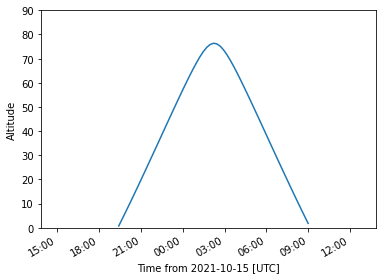

In [13]:
import matplotlib.pyplot as plt
from astropy.time import Time
from astroplan.plots import plot_airmass, plot_altitude

tgt = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=(u.hourangle, u.deg))
now = Time(datetime.now() - timedelta(hours=hourOffset))
plot_altitude(tgt, keckObs, now)
plt.show()

In [14]:
times = get_target_frame().obstime


using yesterday's midnight


In [15]:
t = Time(times, format='jd', scale='utc')

In [19]:
now = Time(datetime.now())
midnight = get_midnight(now)
times = get_times(midnight)

using yesterday's midnight


In [20]:
midnight.iso

'2021-10-15 00:07:27.843'

In [21]:
times.iso

array(['2021-10-14 18:07:27.843', '2021-10-14 18:45:21.527',
       '2021-10-14 19:23:15.212', '2021-10-14 20:01:08.896',
       '2021-10-14 20:39:02.580', '2021-10-14 21:16:56.264',
       '2021-10-14 21:54:49.948', '2021-10-14 22:32:43.633',
       '2021-10-14 23:10:37.317', '2021-10-14 23:48:31.001',
       '2021-10-15 00:26:24.685', '2021-10-15 01:04:18.370',
       '2021-10-15 01:42:12.054', '2021-10-15 02:20:05.738',
       '2021-10-15 02:57:59.422', '2021-10-15 03:35:53.106',
       '2021-10-15 04:13:46.791', '2021-10-15 04:51:40.475',
       '2021-10-15 05:29:34.159', '2021-10-15 06:07:27.843'], dtype='<U23')

In [53]:
def get_midnight(now):
    nearestSet = keckObs.sun_set_time(now, which='nearest')
    utcoffset = hourOffset * u.hour  # Hawaii Daylight Time
    todayMidnight = keckObs.midnight(now, which='next')
    if now < nearestSet: # today's sunrise already occured
        print('using today\'s midnight')
        midnight = Time(todayMidnight) - utcoffset
    else: # today's sunrise has not risen yet
        print('using yesterday\'s midnight')
        yesterdayMidnight = todayMidnight - timedelta(days=1)
        midnight = yesterdayMidnight
    return midnight

def get_times(midnight):
    deltaMidnight = np.linspace(-6, 6, 20)*u.hour
    return midnight+deltaMidnight

def get_target_frame():
    now = Time(datetime.now())
    midnight = get_midnight(now)
    times = get_times(midnight)
    tgtFrame = AltAz(obstime=times, location=keck)
    return tgtFrame

def get_target_traj(ra, dec):
    tgt = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=(u.hourangle, u.deg))
    tgtFrame = get_target_frame()
    tgtTraj = tgt.transform_to(tgtFrame)
    return tgtTraj 

def get_air_mass(ra, dec):
    tgt = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=(u.hourangle, u.deg))
    tgtTraj = get_target_traj(tgt)
    return tgtTraj.secz

def get_parallactic_angle(ra, dec):
    tgt = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=(u.hourangle, u.deg))
    now = Time(datetime.now() - timedelta(hours=hourOffset))
    midnight = get_midnight(now)
    times = get_times(midnight)
    return keckObs.parallactic_angle(times, tgt).deg # in deg

def get_lunar_angle(ra, dec):
    tgt = SkyCoord(ra=ra, dec=dec, frame='icrs', unit=(u.hourangle, u.deg))
    tgtFrame = get_target_frame()
    tgtTraj = tgt.transform_to(tgtFrame)
    now = Time(datetime.now() - timedelta(hours=hourOffset))
    midnight = get_midnight(now)
    times = get_times(midnight)
    moonTraj = get_moon(times, location=keck).transform_to(tgtFrame) # can be costly
    latLngTgtMoon = list(zip(tgtTraj.az, tgtTraj.alt, moonTraj.az, moonTraj.alt))
    latLngTgtMoon = [ [x.radian for x in sublist] for sublist in latLngTgtMoon ]
    angleOfSeparation = [angular_separation(*x) / DEG_TO_RAD for x in latLngTgtMoon] # in deg
    return angleOfSeparation